# Group 2

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel('dataproject2024.xlsx')

## Step 1: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

In [3]:
X = df.drop(columns=['PD'])
y = df['PD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# predict
y_pred_linear = linear_model.predict(X_test)

# Évaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (Linear Regression): {mse_linear}')

Mean Squared Error (Linear Regression): 0.009777721707422917


#### Using a decision tree


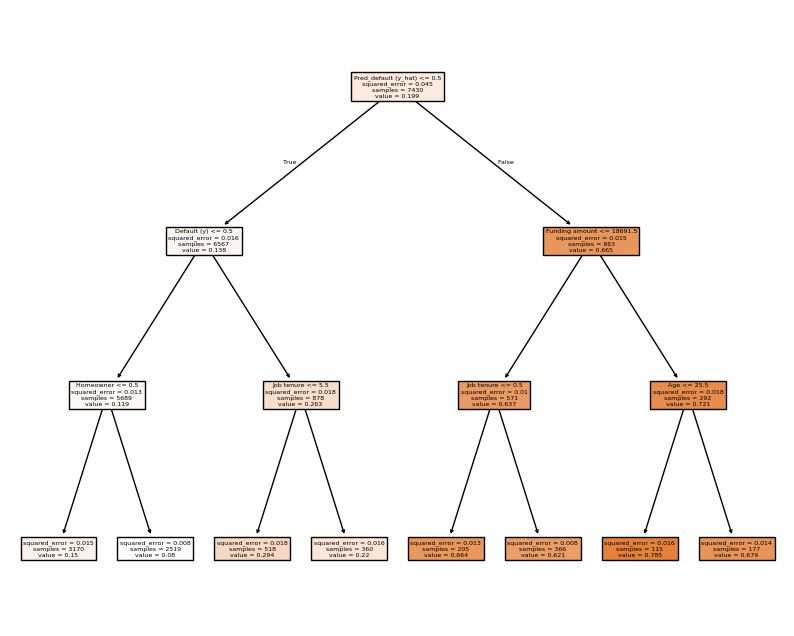

In [4]:
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(10,8))
plot_tree(tree_model, feature_names=X.columns, filled=True)
plt.show()

## Step 2: Estimate your own black-box machine learning model forecasting default. Each model is specific to a group of students and cannot be developed in collaboration with another group.

In [7]:
# Normaliser data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# hyperparameters grid 
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

# hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Ajust and select the best model
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# predict
y_pred = best_model.predict(X_test_scaled)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


## Step 3: Analyze the forecasting performance of your own model.

In [9]:
# performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best params: {grid_search.best_params_}")
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Feature importance
feature_importance = best_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
for idx in sorted_idx[-10:]:  
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}
MSE: 0.0056
R2 Score: 0.8727
Job tenure: 0.0082
Married: 0.0085
Funding amount: 0.0089
Loan duration: 0.0089
Down payment: 0.0114
Credit event: 0.0224
Homeowner: 0.0225
Group: 0.0262
Default (y): 0.0657
Pred_default (y_hat): 0.7967


The low MSE indicates that, on average, the model's predictions deviate by about (√0.0056) from the actual values. The high R2 score shows that the model explains approximately 87.27% of the variance in the data, it means that it captures quite well the majority of the trends. 
However, the model relies heavily on Pred_default (y_hat) and the other freatures has less importance which can lead to mistakes in the predictions and potential overfitting. 

## Step 4: Global interpretability: Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.

Reliability of decision tree as a surrogate model (R2): 0.8934412154387843


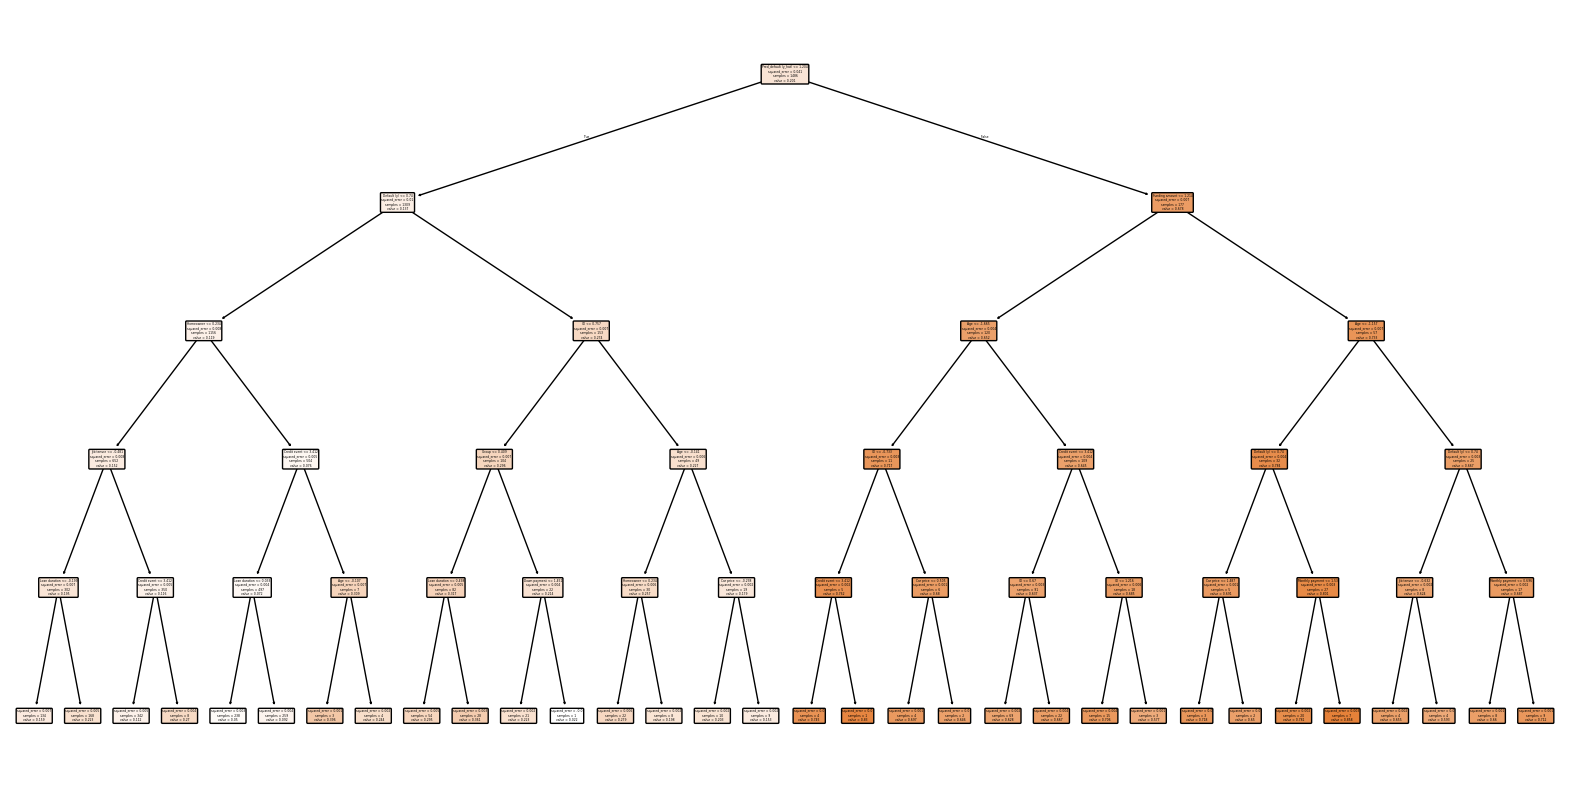


 Feature importance for decision tree:
                 feature  importance
12  Pred_default (y_hat)    0.844373
11           Default (y)    0.061378
10             Homeowner    0.031622
1             Job tenure    0.018866
8           Credit event    0.011523
6          Loan duration    0.011223
2                    Age    0.006543
4         Funding amount    0.004692
0                     ID    0.004458
13                 Group    0.003436


In [11]:
# Predict the xgb model
y_pred_xgb = best_model.predict(X_test_scaled)

# decision tree as surrogate model
dt_surrogate = DecisionTreeRegressor(max_depth=5)
dt_surrogate.fit(X_test_scaled, y_pred_xgb)

dt_fidelity = r2_score(y_pred_xgb, dt_surrogate.predict(X_test_scaled))

print("Reliability of decision tree as a surrogate model (R2):", dt_fidelity)


plt.figure(figsize=(20,10))
plot_tree(dt_surrogate, feature_names=X.columns, filled=True, rounded=True)
plt.show()

# feature importance 
dt_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_surrogate.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Feature importance for decision tree:")
print(dt_feature_importance.head(10))

## Step 5: Global interpretability: Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.

## Step 6: Local interpretability: Implement the ICE method to interpret your own model.

## Step 7: Local interpretability: Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.

## Step 8: Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model. Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7).

## Step 9: Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity (groups are given in the dataset). Discuss your results.

## Step 10: Implement a FPDP using a fairness measure. Discuss your results.